## 3) [NVIDIA](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) + cropping+ normalization + Data Augmenting 180-flipped images +  5-epochs + Generators

In [1]:
# Importing all required libraries
import os
import time
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Images resizing and pre-processing
def image_preprocess(img):
    
    # original Image shape is:  160x320x3 while input shape for the Nvidia model is:  66x200x3
    # crop to 40x320x3
    #n_img = img[50:140,0,0]
    n_img = cv2.GaussianBlur(img, (3,3), 0)
    # scale to 66x200x3 (same as nVidia), and as suggested by the Cheatsheet
    #n_img = cv2.resize(n_img,(200, 66), interpolation = cv2.INTER_AREA)
    # convert to YUV color space (as Hinted in the project )
    n_img = cv2.cvtColor(n_img, cv2.COLOR_BGR2YUV)
    return n_img
print('end')

end


size of original training_set=  2222
size of original validation_set=  556


Using TensorFlow backend.


Epoch 1/3
70/69 [==============================] - 319s 5s/step - loss: 0.7834 - val_loss: 0.2297
Epoch 2/3
70/69 [==============================] - 318s 5s/step - loss: 0.1603 - val_loss: 0.1315
Epoch 3/3
70/69 [==============================] - 320s 5s/step - loss: 0.1189 - val_loss: 0.1181
Time fit_generator for 2222 samples: 958.5394027233124
dict_keys(['val_loss', 'loss'])


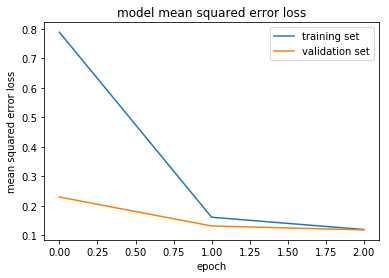

end


In [3]:

samples = []
i = 0
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(i > 0): #this part is added to insure the 1st line in the csvfile which include the headers is not included
             samples.append(line)
        i = i + 1

        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('size of original training_set= ', len(train_samples))
print('size of original validation_set= ', len(validation_samples))

def generator(samples, batch_size=32):
    '''
    Using generators to be able to train and validate on limited memory 
    '''
    correction = 0.2 # steering angle correction is a parameter to tune
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # extract the center image path from the .cvs file
                source_path= batch_sample[0]
                # the following 3 lines is used to extract just the image name without local path on local machine where data is collected
                filename =source_path.split('C:')[-1]
                filename =source_path.split('\\')[-1]
                filename =source_path.split('/')[-1]
               # print('filename after line split: ', filename)
                # update image path to the current folder on the AWS
                current_path= 'data/IMG/'+filename
                #print("center_image current_path is: ", current_path)
                center_image = cv2.imread(current_path)
                center_image = image_preprocess(center_image)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                images.append(cv2.flip(center_image, 1)) #flip image 180 horizontally
                angles.append(center_angle * -1.0) # reverse the steering angle
                
                
                name_left = 'data/IMG/'+batch_sample[1].split('\\')[-1]
                name_left = 'data/IMG/'+batch_sample[1].split('/')[-1]
               # print('filename after line split: ', name_left)
                left_image = cv2.imread(name_left)
                left_angle = center_angle + correction
                images.append(left_image)
                angles.append(left_angle)
                
                name_right = 'data/IMG/'+batch_sample[2].split('\\')[-1]
                name_right = 'data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name_right)
                right_angle = center_angle - correction
                images.append(right_image)
                angles.append(right_angle)
                

            # Convert to numpy float arrays.
            X_train = np.array(images)
            y_train = np.array(angles)
            # Shuffle the data for every batch
            yield sklearn.utils.shuffle(X_train, y_train)


# display sample image and it's corresponding label (steerng angle)
#print(X_train[0].shape, ' shape of train samples')
#print(" a sample of label before flipping", y_train[4823])
#print(" a sample of label after  flipping", y_train[4824])
#print("size of training set", len(X_train))            



ch, row, col = 3, 80, 320  # Trimmed image format

import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense  
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras import regularizers
#from keras.utils.visualize_util import plot


model = Sequential()

# Cropping un-useful details from the image to avoid distracting model training. Here I removed 60-pixels from top and 20 pixels from bottom.
model.add(Cropping2D(cropping=((60,20), (0,0)),  input_shape = (160,320,3)))

# Preprocessing the data using Normalization and Mean-Center and using trimmed image format to perform cropping
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(80,320,3),  output_shape = (80,320,3)))


                    
# Using NVIDIA model 
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2), kernel_regularizer=regularizers.l2(0.01)))
#model.add(MaxPooling2D())
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2), kernel_regularizer=regularizers.l2(0.01)))
#model.add(MaxPooling2D())
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


# compile and train the model using the generator function
# Generate training and validation datasets and run the model in batches, where batch_size= 32
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

samples_per_epoch = len(train_samples)
batch_size = 32
steps_per_epoch = samples_per_epoch/batch_size

model.compile(loss='mse', optimizer='adam')

start = time.time()
#history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=3)
history = model.fit_generator(train_generator, validation_steps=len(validation_samples), steps_per_epoch=steps_per_epoch, epochs=3, validation_data=validation_generator)
print("Time fit_generator for %s samples: %s" % (len(train_samples), time.time() - start))

# save the model to reuse or download
model.save('model.h5')



### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()          


# NOTE: by default Keras train for 10 epochs

# visualize model layout with pydot_ng
#plot(model, to_file='model.png', show_shapes=True)
print ('end')
